## Data preparation

In [1]:
import numpy as np
import pandas as pd

In [2]:
waterdf = pd.read_csv("../dataset/water_potability.csv")

In [3]:
waterdf.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
waterdf.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

## Explanatory Data Analysis

In [5]:
waterdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [6]:
# From this information, we can notice that:
# All columns are numeric (9 float and 1 integer)
# Many columns contains null values

In [7]:
# We check if there are missing values
waterdf.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [8]:
# There is missing values in columns ph, Sulfate and Trihalomethanes
# We'll replace them by the mean

missing_columns = ['ph', 'Sulfate', 'Trihalomethanes']
for col in missing_columns:
    waterdf[col].fillna(waterdf[col].mean(), inplace=True)

In [9]:
# We check if there are duplicated values
waterdf.duplicated().sum()

0

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

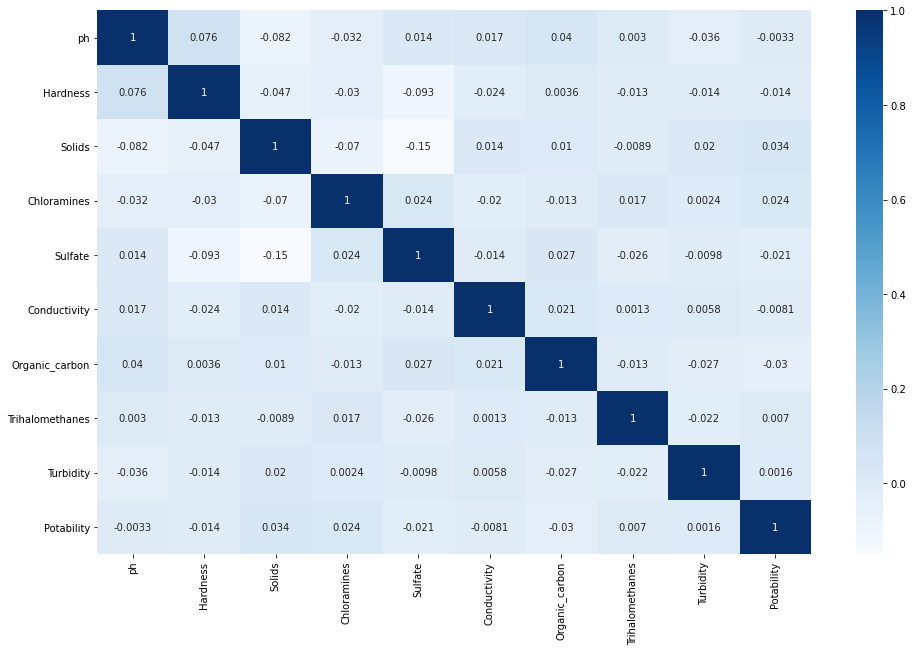

In [11]:
plt.figure(figsize=(16,10))
sns.heatmap(waterdf.corr(), cbar=True, annot=True, cmap='Blues')

In [12]:
# If we observe that plot, we can see there is small correlation between columns
# Then, all columns should be considered 


#As we are on binary classification (0 for non-potable and 1 for potable) let's visualize the amount of each value

In [13]:
x = waterdf['Potability'].value_counts()

([<matplotlib.patches.Wedge at 0x7f20e7a34a90>,
 [Text(-0.3722543665175176, 1.0350974285586076, 'Non-potable'),
  Text(0.3722543665175174, -1.0350974285586076, 'Potable')],
 [Text(-0.2030478362822823, 0.5645985973956041, '61.0%'),
  Text(0.2030478362822822, -0.5645985973956041, '39.0%')])

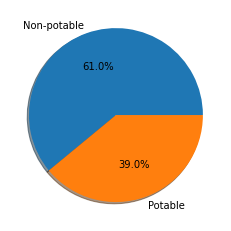

In [14]:
labels = ['Non-potable', 'Potable']
sizes =  [waterdf['Potability'].value_counts()[0], waterdf['Potability'].value_counts()[1]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)

In [15]:
# There is 3/5 of the dataset that is for Non-potable water and 2/5 for potable water
# We can then use traditional train_test_split

## Splitting data

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y = waterdf.Potability
X = waterdf.drop(['Potability'], axis=1)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

## Modeling

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [20]:
param_grid = {
    "max_depth": [3], #[3, 4, 5, 7],
    "learning_rate": [0.1], #[0.1, 0.01, 0.05],
    "gamma": [0], #[0, 0.25, 1],
    "reg_lambda": [0], #[0, 1, 10],
    "scale_pos_weight": [1], #[1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

xgb_cl = XGBClassifier(objective='binary:logistic')
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
grid_cv.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:28:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [21]:
print (f"Best score is {grid_cv.best_score_} and best params are {grid_cv.best_params_}")

Best score is 0.6156260273490018 and best params are {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1, 'subsample': 0.8}


In [22]:
final_cl = XGBClassifier(**grid_cv.best_params_,
                objective="binary:logistic"
                )
final_cl.fit(X_train, y_train)

[18:29:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
val_predicted = final_cl.predict(X_valid)
print (f"accuracy score is {accuracy_score(y_valid, val_predicted) * 100}%")

accuracy score is 67.6829268292683%
